# Learning the Wave Equation

See the library `nn_1d_pde` for more on this problem.

In [ ]:
import numpy as np
import seaborn
from matplotlib import pylab as plt
from matplotlib import cm
plt.style.use('seaborn-paper')
import sympy

In [876]:
import utils
import plotting
import helper
import analytical_solutions
import models
import ode_helper
# Hack for reloading in notebooks without reseting the kernel
import importlib
importlib.reload(utils)
importlib.reload(helper)
importlib.reload(plotting)
importlib.reload(models)
importlib.reload(ode_helper)
importlib.reload(analytical_solutions)

from helper import *
from utils import *
from analytical_solutions import *
from ode_helper import *

In [462]:
device=get_device()
set_seed()

Using the CPU


In [566]:
device=get_device()
set_seed()

In [ ]:
ts, data = make_wave_dataset(10, 500, t_max=83,
                             params=WAVE_PARAMS[1])
torch_data = data_to_torch(data, device=device)
torch_ts = data_to_torch(ts, device=device)
NT,_,NX = data.shape
dt = ts[1]-ts[0]
data.shape

In [ ]:
plt.subplot(1,2,1)
for i in range(0,NT,NT//10):
    plt.plot(data[i,0,:])
plt.subplot(1,2,2)
for i in range(0,NT,NT//10):
    plt.plot(data[i,1,:])

In [ ]:
plt.plot(data[:,0,NX//2])
plt.plot(data[:,1,NX//2])
plt.xlim(100,200)

In [799]:
model = models.MultiLinear((2,NX),(2,NX),bias=False).double().to(device)

In [800]:
save_schedule = [2.0**-i for i in range(-1,100)]
next_save = save_schedule.pop(0)
all_omegas = []
all_metrics = []
def callback(model, opt_iter, loss):
    global next_save, all_omegas
    if loss < next_save:
        
        Om = model.net.weight.detach().cpu().numpy().copy()
        all_omegas.append(Om)
        all_metrics.append((opt_iter,loss))
        print("Saving at ",opt_iter, " with loss ",loss)
        next_save = save_schedule.pop(0)

Using the CPU


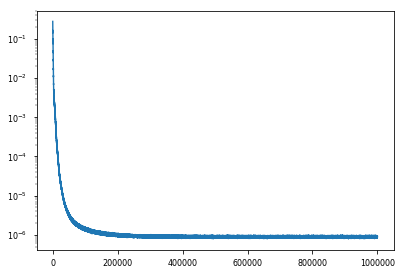

In [801]:
_,losses=learn_rnn(torch_data, model, N_iter=60000,
                   batch_size=250,learning_rate=1.0e-4,
                   N_print=100,
                  callback=callback, gamma=1e-5)
plt.semilogy(losses)

In [727]:
def integrate_rnn(Omega, u0, nsteps):
    shape = u0.shape
    us = [u0]
    for i in range(nsteps):
        un = Omega @ u0.flatten()
        us.append(un.reshape(shape))
        u0 = un
    return np.concatenate(us,axis=0)

In [803]:
np_omegas=np.array(all_omegas)
UVs = [integrate_rnn(np_omegas[i,:,:], torch_data[0:1,:,:].cpu().numpy(), 25 )
       for i in range(np_omegas.shape[0]) ]

In [ ]:
ani = plotting.make_animation(np_omegas,interval=1,transpose=False)
plotting.HTML(ani)

In [ ]:
import matplotlib.animation as animation
import cmocean

## Make an animation of the traditional ML method

In [856]:
def make_animation(img, metrics, interval=10, transpose=True):
    fig, ax = plt.subplots(figsize=(6,3))
    minmax = np.max(np.abs(img)) * 0.65
    tr = lambda x : x.T if transpose else x
    ax_left = plt.subplot(1,2,1)
    ax_left.set_title(f"Iteration #{metrics[0][0]}     Loss = {metrics[0][1]:1.2e}")
    canvas = plt.imshow(tr(img[0,:,:]), interpolation='none',
                        cmap=cmocean.cm.balance, 
                        #interpolation='bicubic', 
                        vmin=-minmax, vmax=minmax)
    plt.axis('off')
    plt.text(-3,5,'$\\frac{du}{dt}$',fontsize=16)
    plt.text(-3,15,'$\\frac{dv}{dt}$',fontsize=16)
    plt.text(5,21,'$u$')
    plt.text(15,21,'$v$')
    ax = plt.subplot(1,2,2)
    ax.set_ylim((-0.5, 0.5))
    ax.set_title("$u(x,t)$")
    xs = np.linspace(0,1,UVs[0].shape[-1])
    line, = ax.plot(xs,UVs[0][0,0,:], lw=2)
    plt.tight_layout()
    def animate(i):
        frame = i//UVs[0].shape[0]
        time = i%UVs[0].shape[0]
        ax_left.set_title(f"Iteration #{metrics[frame][0]}     Loss = {metrics[frame][1]:1.2e}")
        line.set_data(xs,UVs[frame][time,0,:])
        canvas.set_array(tr(img[frame,:,:]))
        return canvas,
    ani = animation.FuncAnimation(fig, animate, frames=img.shape[0]*UVs[0].shape[0],
                                  interval = interval)
    return ani

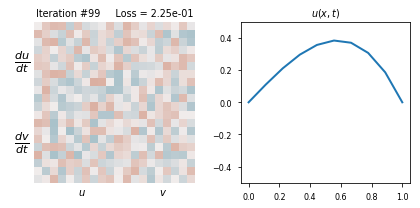

In [857]:
ani = make_animation(np_omegas,all_metrics,interval=1, transpose=False)

In [859]:
ani.save('wave_animation.mp4',fps=30,dpi=120)

In [ ]:
anij = ani.to_jshtml()
plotting.HTML(anij)

In [862]:
all_lambdas = [ lambda_of_omega(om) for om in all_omegas ]

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:4: ComplexWarning: Casting complex values to real discards the imaginary part
  after removing the cwd from sys.path.


/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


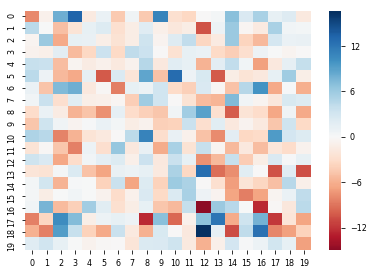

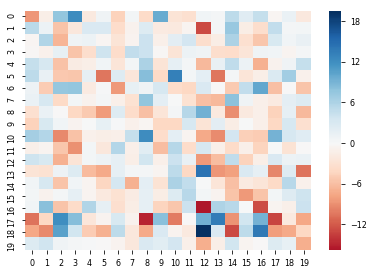

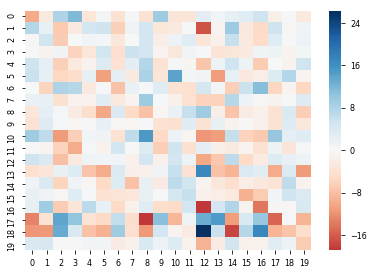

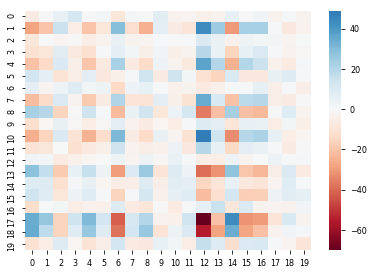

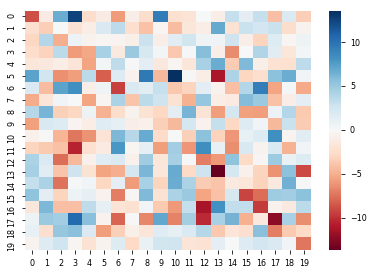

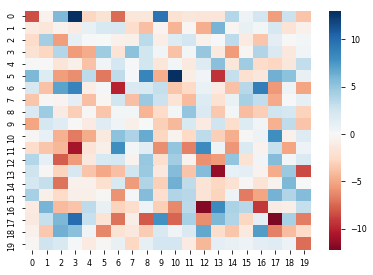

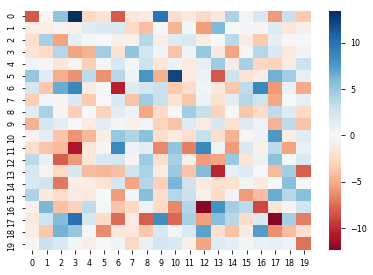

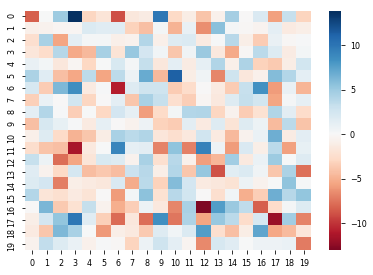

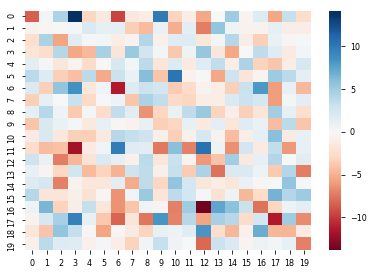

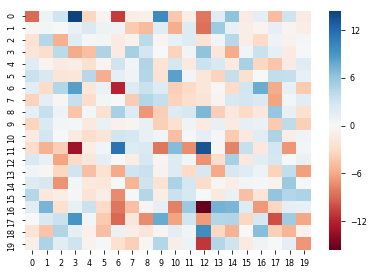

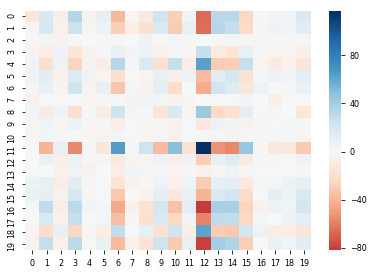

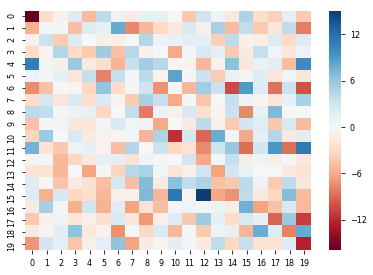

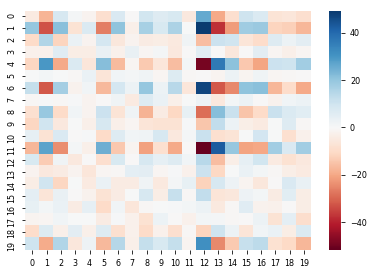

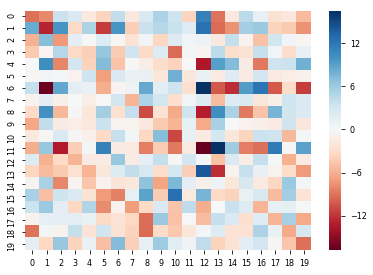

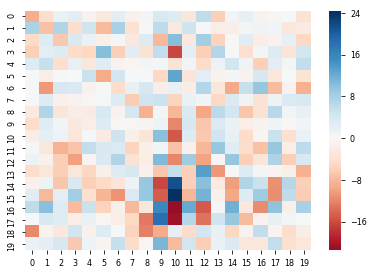

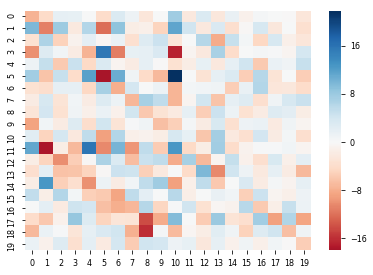

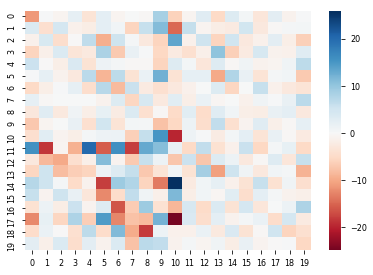

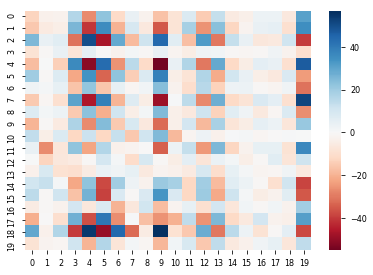

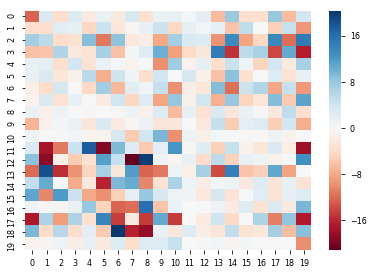

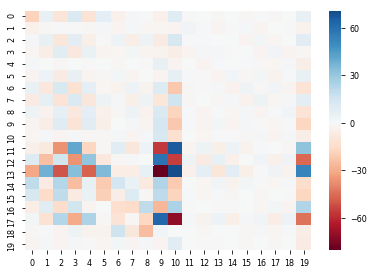

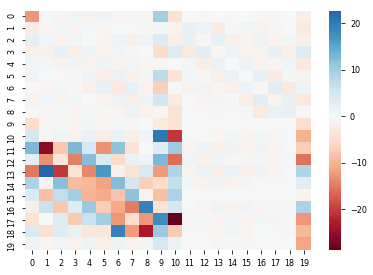

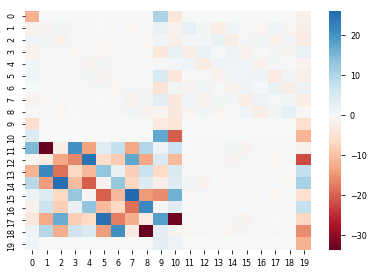

<Figure size 460.8x316.8 with 0 Axes>

In [ ]:
for l in all_lambdas:
    seaborn.heatmap(l, cmap='RdBu', center=0)
    plt.figure()

In [ ]:
UV = integrate_model(model, torch_data[0:1,:,:],nsteps=25)
plt.subplot(1,2,1)
for i in range(UV.shape[0]):
    plt.plot(UV[i,0,:])
plt.subplot(1,2,2)
for i in range(UV.shape[0]):
    plt.plot(UV[i,1,:])

In [ ]:
Omega = model.net.weight.detach().cpu().numpy()
w,V = np.linalg.eig(Omega)
#Lambda = V.dot( np.diag(np.log(w)/dt).dot(np.linalg.inv(V)))
Lambda = 1/dt * V @ np.diag(np.log(w)) @ np.linalg.inv(V)
Lambda = np.array(Lambda,dtype=np.double)

In [ ]:
plt.figure(figsize=plotting.FIG_SIZE_FULL)
plt.subplot(1,2,1)
plt.title('Omega')
seaborn.heatmap(Omega, cmap='RdBu', center=0)
plt.subplot(1,2,2)
plt.title('Lambda')
seaborn.heatmap(Lambda, cmap='RdBu', center=0)

# Using the ODEs

In [866]:
class MultiLinearODE(models.MultiLinear):
    """MultiLinear with a t"""
    def __init__(self, *args, **kwargs):
        super(MultiLinearODE,self).__init__(*args,**kwargs)
    def forward(self, t, x):
        xflat = torch.flatten(x, start_dim=-len(self.in_dims))
        hflat = self.net(xflat)
        return torch.reshape( hflat, hflat.shape[:-1]+self.out_dims )

In [867]:
model_ode = MultiLinearODE((2,NX),(2,NX),bias=False).double()

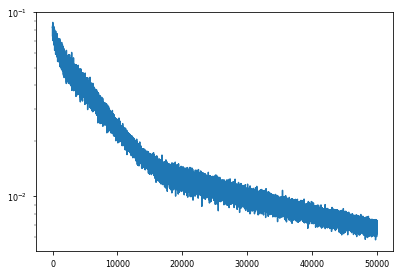

In [868]:
_,losses=train_a_neural_ode(torch_data, torch_ts, model_ode,
                            device=device, )
plt.semilogy(losses)

In [ ]:
model_multi = MultiLinearODE((2,NX),(2,NX),bias=False).double()

In [ ]:
_,losses=train_a_neural_ode_multi_method(torch_data, torch_ts, model_multi,
                                         device=device)
plt.semilogy(losses)

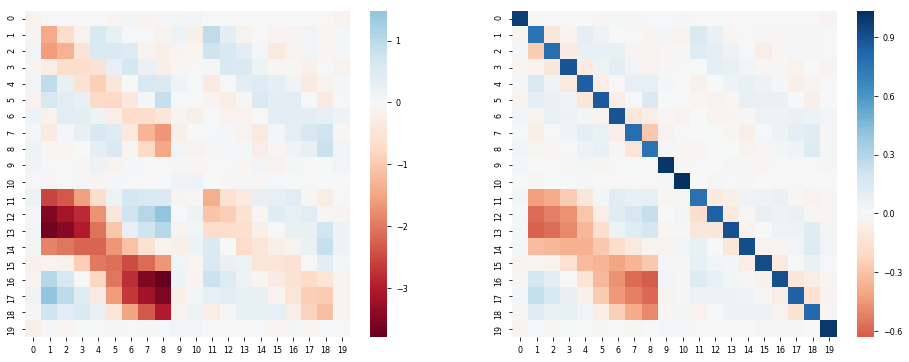

In [891]:
plt.figure(figsize=plotting.FIG_SIZE_FULL)
plt.subplot(1,2,1)
LambdaODE = model_ode.net.weight.detach().cpu().numpy()
seaborn.heatmap(LambdaODE, cmap='RdBu', center=0)
plt.subplot(1,2,2)
OmegaODE = operator_factory(LambdaODE, dt)
seaborn.heatmap(OmegaODE, cmap='RdBu', center=0)

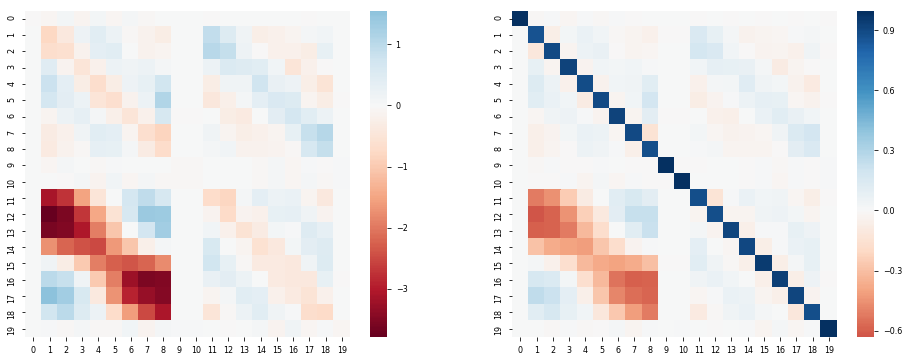

In [892]:
plt.figure(figsize=plotting.FIG_SIZE_FULL)
plt.subplot(1,2,1)
LambdaMult = model_multi.net.weight.detach().cpu().numpy()
seaborn.heatmap(LambdaMult, cmap='RdBu', center=0)
plt.subplot(1,2,2)
OmegaMult = operator_factory(LambdaMult, dt)
seaborn.heatmap(OmegaMult, cmap='RdBu', center=0)